In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft, optimize, stats, signal, special, interpolate, ndimage
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing as mp
import freud


In [2]:
plt.rcParams['text.usetex'] = True 
plt.rcParams.update({"text.usetex":True, "font.family":"Computer Modern"})

In [3]:
from scipy.optimize import curve_fit

In [4]:
import sys
sys.path.insert(1, '../../')


from analyse_DCT import *

In [5]:
def get_conf(data):
    Nf = data["Chromosome index"].iloc[-1]
    N = (data["Chromosome index"]==1).sum()   
    print(N, Nf) 
    conformations = np.zeros((Nf,N,3))
    for k in range(Nf):
        conformations[k,:,:] = data[['X','Y','Z']][data['Chromosome index'] == k+1].interpolate(method = 'linear', limit_direction = 'both').to_numpy()
    return conformations

def lin(x,a,b):
    return a*x+b

In [6]:
data = pd.read_csv('raw_data/IMR90_28-30_untreated_cellcycle.csv', header=1)

In [7]:
def make_dict(path):
    data = pd.read_csv(path, header=1)
    print(path)
    dic = {'N' : (data["Chromosome index"]==5).sum(),
        'Nf' : data["Chromosome index"].iloc[-1],
        'conf' : get_conf(data),
        'type' : str(path)[9:-4].split('_')[0],
        'region' : str(path)[9:-4].split('_')[1],
        'title' : str(path)[9:-4],
        'treatment' :  str(path)[9:-4].split('_')[2]
        }
    return dic



path_raw_data = Path('raw_data')
paths = [path for path in path_raw_data.iterdir() if path not in [Path('raw_data/README.md'), Path('raw_data/IMR90_STORM_overlap.csv'), Path('raw_data/IMR90_STORM_overlap.csv'), Path('raw_data/IMR90_28-30_untreated_cellcycle.csv'), Path('raw_data/K562_28-30_untreated.csv')]]

# select two datasets 
selected_paths = [paths[0], paths[6]]

to_study_dicts = [make_dict(path) for path in selected_paths]

raw_data/HCT116_34-37_untreated.csv
83 11631
raw_data/HCT116_34-37_6h-auxin.csv
83 9526


In [8]:
from NN_trainer import *


import multiprocessing as mp


import multiprocessing  
from multiprocessing import Pool

import matplotlib.colors as colors

from lambdaplot_helperfunctions import *

In [9]:
for j, dict in enumerate(to_study_dicts):
    print(dict["treatment"])

untreated
6h-auxin


In [10]:
for dict in to_study_dicts:
    conf = dict['conf']
    Ns, N = np.shape(conf)[0:2]
    print(np.max( scipy.spatial.distance.squareform(  np.mean( [ scipy.spatial.distance.pdist(conf[j,:,:]) for j in range(Ns) ] , axis = 0) ) ))

847.5788429186654
978.2341108497974


# Create median distance maps

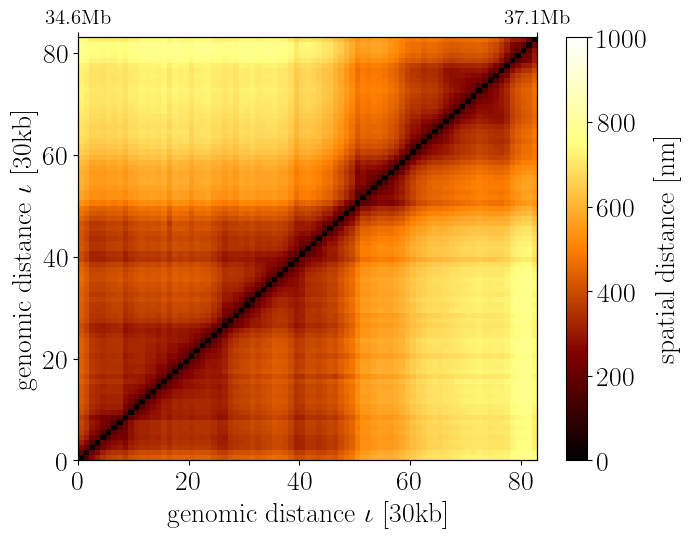

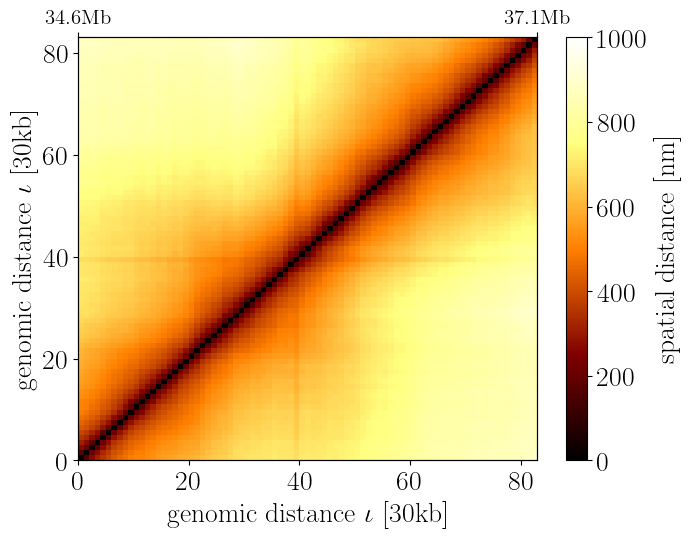

In [11]:
for dict in to_study_dicts:
    conf = dict['conf']
    Ns, N = np.shape(conf)[0:2]

    fig, ax = plt.subplots()

    plt.tight_layout()
    
    
    

    im= ax.pcolormesh( scipy.spatial.distance.squareform(  np.median( [ scipy.spatial.distance.pdist(conf[j,:,:]) for j in range(Ns) ] , axis = 0) ),cmap = "afmhot", vmin = 0, vmax = 1000, linewidth=0,rasterized=True )
    
    
    ax2 = ax.twiny()
    ax2.set_xticks([0,N])
    ax2.set_xticklabels(["$34.6 \\textrm{Mb}$", "$37.1 \\textrm{Mb}$"], fontsize = 15)


    ax.set_xlabel('genomic distance $\\iota$ $[30 \\textrm{kb}]$', fontsize = 20)
    ax.set_ylabel('genomic distance $\\iota$ $[30 \\textrm{kb}]$', fontsize = 20)


    

    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('spatial distance $[\\textrm{nm}]$', fontsize = 20)

    ax.set_xticks([0,20,40,60,80])
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    cbar.ax.yaxis.set_tick_params(labelsize=20)

    
    
    plt.savefig("fig_io/experimental_distances_"+dict['treatment']+".pdf", bbox_inches='tight')
    plt.show()

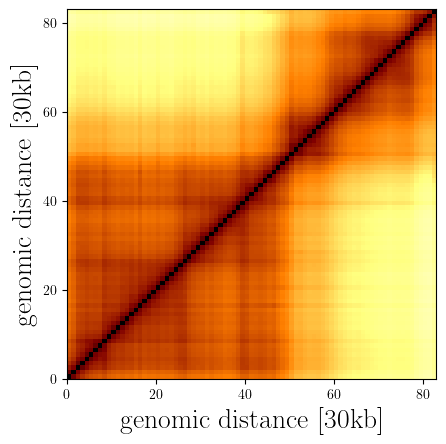

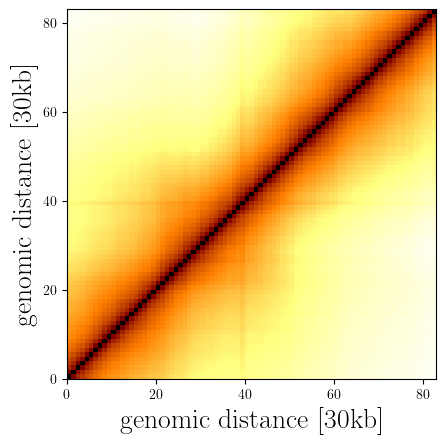

In [12]:
for dict in to_study_dicts:
    conf = dict['conf']
    Ns, N = np.shape(conf)[0:2]

    fig, ax = plt.subplots()


    im= ax.pcolormesh( scipy.spatial.distance.squareform(  np.mean( [ scipy.spatial.distance.pdist(conf[j,:,:]) for j in range(Ns) ] , axis = 0) ),cmap = "afmhot", vmin = 0, vmax = 1000, linewidth=0,rasterized=True )
    

    ax.set_xlabel('genomic distance $[30 \\textrm{kb}]$', fontsize = 20)
    ax.set_ylabel('genomic distance $[30 \\textrm{kb}]$', fontsize = 20)


    ax.set_xticks([0,20,40,60,80])
    ax.set_yticks([0,20,40,60,80])

    ax.axes.set_aspect('equal')
    plt.savefig("fig_io/experimental_distances_"+dict['treatment']+"_square.pdf"
            , bbox_inches='tight')
    plt.show()

In [13]:
# number of frames:
print( to_study_dicts[0]["Nf"] )
print( to_study_dicts[1]["Nf"] )

11631
9526


## Compute Lambda-plot

In [14]:


for dict in to_study_dicts:
    conf = dict['conf']

    N = np.shape(conf)[1]
    Ns = np.shape(conf)[0]

    mode1 = np.zeros((N//2+N%2,N))
    mode2 = np.zeros((N//2+N%2,N))
    mode3 = np.zeros((N//2+N%2,N))
    mode4 = np.zeros((N//2+N%2,N))


    for n_halve in range(3, int(N//2+N%2) ):
        for i_mid in range( n_halve, N-n_halve ):
            
            n = 2*n_halve
            conf_ = conf[:,i_mid - n_halve:i_mid+n_halve+1]

            spec = modes2(conf_)
            
            mode1[n_halve,i_mid] = np.log(spec[1])
            mode2[n_halve,i_mid] = np.log(spec[2])
            mode3[n_halve,i_mid] = np.log(spec[3])
            mode4[n_halve,i_mid] = np.log(spec[4])

    p1_pred = - (mode4-mode2) / (np.log(4) - np.log(2)) *np.log(2) +mode2

    lambdaplot_Z = p1_pred-mode1


    dict["lambdaplot"] = ( np.arange(N), 2*np.arange(0,N//2+N%2), lambdaplot_Z )



## Detect maxima in Lambda-plot

In [15]:
from skimage.feature import peak_local_max

def get_loops_from_lambda(lambdaplotinfo, threshold_abs, min_distance, min_loop_size, bot_lim, mid_lim, nn_threshold):
    """
    Identifies the locations of loops within a lambda-plot by analyzing the intensity of the nearest neighbor pixels around detected loops. The function utilizes the peak_local_max method from the scipy library to detect peaks based on given parameters. The detected loops are further filtered based on their intensity values and spatial relationships to ensure accurate identification.

    Parameters:
    lambdaplotinfo (tuple): A tuple containing plot information where lambdaplotinfo[2] is the intensity matrix of the plot.
    threshold_abs (float): The threshold value for peak detection using peak_local_max.
    min_distance (int): The minimum number of pixels required between two peaks for them to be considered separate detections.
    min_loop_size (int): The minimum size of a loop for it to be considered in the detection process.
    bot_lim (int): The threshold number of pixels in the 3-nearest neighbors of a detected loop (of size min_loop_size) that must have intensity values greater than nn_threshold.
    mid_lim (int): The threshold number of pixels in the 4-nearest neighbors of a detected loop that must have intensity values greater than nn_threshold.
    nn_threshold (float): The intensity threshold for nearest neighbor pixels, set to 0.05 in the reference article.

    Returns:
    loop_coordinates (numpy.ndarray): An array of coordinates for the detected loops after filtering, with coordinates adjusted by a factor of mu_0.
    max_coordinates (numpy.ndarray): An array of initial detected peak coordinates before filtering.

    Process:
    1. Peak Detection: Use peak_local_max to detect local maxima in the intensity matrix lambdaplotinfo[2] based on threshold_abs and min_distance.
    2. Filtering: Iterate through detected peaks and apply various checks based on their position and intensity of neighboring pixels:
        - Edge Cases: Handle special cases for peaks at the left, right, and bottom edges.
        - Mid Cases: Apply mid case filtering based on the intensity values of 4-nearest neighbors compared to mid_lim.
    3. Loop Coordinates Adjustment: Adjust the coordinates of detected loops by a factor of mu_0 and return the final loop coordinates along with the original peak coordinates.
    """

    max_coordinates = peak_local_max(lambdaplotinfo[2], min_distance=min_distance, threshold_abs = threshold_abs, exclude_border=False)
    ind = []
    N = len(lambdaplotinfo[0])
    mu_0=1.34767
    for nth, [n, i_mid] in enumerate(max_coordinates): # check max width
        if n < lambdaplotinfo[2].shape[0]-1 :
            left, right, top, bottom = lambdaplotinfo[2][n, i_mid - 1], lambdaplotinfo[2][n, i_mid + 1], lambdaplotinfo[2][n + 1, i_mid], lambdaplotinfo[2][n - 1, i_mid]
            # Left edge cases
            if i_mid == n: 
                if (right < nn_threshold) or (bottom < nn_threshold):
                    ind.append(nth)

            # Right edge cases
            elif i_mid == N-n-1: 
                if (left < nn_threshold) or (bottom < nn_threshold):
                    ind.append(nth)
            
            #bottom edge cases:
            elif n==min_loop_size: 
                if (np.array([left, right, top]) > nn_threshold).sum() < bot_lim:
                    ind.append(nth)  

            # mid cases  
            else:
                if (np.array([left, right, top, bottom]) > nn_threshold).sum() < mid_lim:
                    ind.append(nth)
    max_coordinates = np.delete(max_coordinates, ind, axis = 0)

    loop_coordinates = np.zeros(max_coordinates.shape)
    loop_coordinates[:] = max_coordinates[:]
    loop_coordinates[:,0] = (np.round(max_coordinates[:,0]/mu_0)).astype(int)
    return  loop_coordinates[np.argsort(max_coordinates[:,1])], max_coordinates[np.argsort(max_coordinates[:,1])]



In [16]:
maxwt =get_loops_from_lambda(to_study_dicts[0]['lambdaplot'], 0.1, 1, 2, 2, 2, 0.05)[1]*np.array([2,1])
maxA = get_loops_from_lambda(to_study_dicts[1]['lambdaplot'], 0.1, 1, 2, 2, 2, 0.05)[1]*np.array([2,1])

maxwt[:, [0, 1]] = maxwt[:, [1, 0]]
maxA[:, [0, 1]] = maxA[:, [1, 0]]


In [17]:
all_maxpos = np.array([ maxwt, maxA ]) 


/var/folders/w3/n3zdhx3j4f11dwgk9b9chdjc0000gn/T/ipykernel_1729/2982129013.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_maxpos = np.array([ maxwt, maxA ])


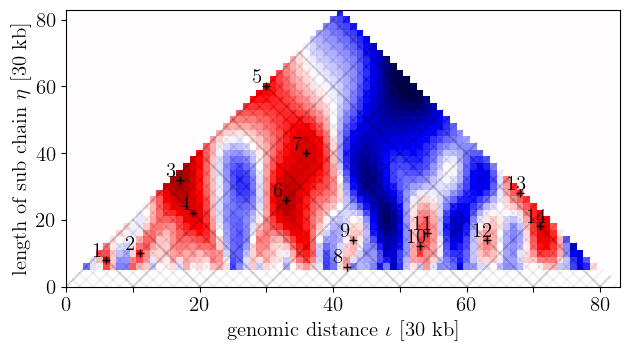

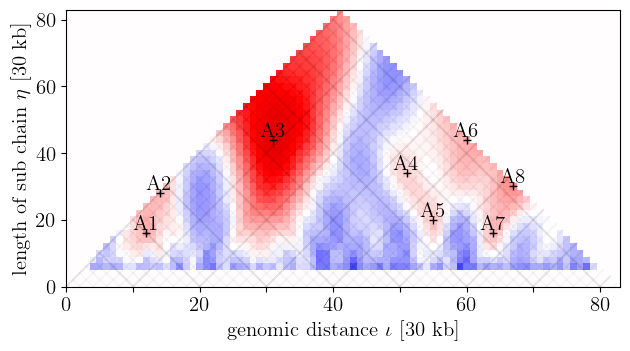

In [18]:


for j, dict in enumerate(to_study_dicts):
    fig, ax = plt.subplots()
    im = ax.pcolormesh( dict["lambdaplot"][0], dict["lambdaplot"][1],dict["lambdaplot"][2], cmap="seismic", vmin = -1.2, vmax=1.2, linewidth=0,rasterized=True)

    ax.set_xlabel('genomic distance $\\iota$ [30 kb] ', fontsize=15)
    ax.set_ylabel('length of sub chain $\\eta$ [30 kb] ', fontsize=15)
    ax.set_xlim(0,N)
    ax.set_ylim(0,N)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)

    ax.set_xticks([0,10,20,30,40,50,60,70,80])
    ax.set_xticklabels([0,"",20,"",40,"",60,"",80])



    for k, (x,y) in enumerate(all_maxpos[j]):
        



        ax.plot( x, y, '+', color = "black" )

        lambda_grid(ax,N, N_minor_ticks = 5, alpha=.01 ) 


        

        
        if j == 0:
            ax.annotate(str(k+1), (x,y), (x-2,(y+1)), fontsize=15)
        else:
            ax.annotate("A"+str(k+1), (x,y), (x-2,(y+1)), fontsize=15)

    

    #ax.set_aspect("equal")
    ax.set_aspect(1/2)
    plt.tight_layout()
    name = "experimental_Lambda_plot_numbered_" + dict['treatment'] + ".pdf"
    plt.savefig("./" + name, dpi = 300)
    plt.show()


## Neural networks segregation

In [19]:

learn_samples_per_category = 25000
validation_samples_per_category = 7500
test_samples = 5000



models = []
histories = []
resulttests = []


for all_maxpos_ in all_maxpos:
    for imid,eta in all_maxpos_:

        print(imid, eta )
        imid = int(imid)
        eta = int(eta)

        std_loopsize = int(np.round(0.1*eta)) 
        resolution = 30 

        model, history, resulttest = NNmaker(eta, std_loopsize, resolution, learn_samples_per_category, validation_samples_per_category, test_samples)

        models.append(model)
        histories.append(history)
        resulttests.append(resulttest)

        

6 8
train model


2024-07-20 12:05:28.859559: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Testing model
11 10
train model
Testing model
17 32
train model
Testing model
19 22
train model
Testing model
30 60
train model
Testing model
33 26
train model
Testing model
36 40
train model
Testing model
42 6
train model
Testing model
43 14
train model
Testing model
53 12
train model
Testing model
54 16
train model
Testing model
63 14
train model
Testing model
68 28
train model
Testing model
71 18
train model
Testing model
12 16
train model
Testing model
14 28
train model
Testing model
31 44
train model
Testing model
51 34
train model
Testing model
55 20
train model
Testing model
60 44
train model
Testing model
64 16
train model
Testing model
67 30
train model
Testing model


In [20]:
modelswt = np.array(models[:len(all_maxpos[0])])
modelsA = np.array(models[len(all_maxpos[0]):])

historieswt = np.array(histories[:len(all_maxpos[0])])
historiesA = np.array(histories[len(all_maxpos[0]):])

resulttestswt = np.array(resulttests[:len(all_maxpos[0])])
resulttestsA = np.array(resulttests[len(all_maxpos[0]):])

In [21]:

fp_wt = np.sum( resulttestswt[:, :test_samples] < 0.5, axis = 1 ).reshape(-1)

fn_wt = np.sum( resulttestswt[:, test_samples:] > 0.5, axis = 1 ).reshape(-1)

acc = 1 - (fp_wt + fn_wt)/(2*test_samples)
print(acc)
print((np.round(acc*100)).astype(int))

[0.8506 0.9329 0.943  0.9434 0.9307 0.9277 0.9397 0.7942 0.5    0.9332
 0.9251 0.9494 0.9321 0.9331]
[85 93 94 94 93 93 94 79 50 93 93 95 93 93]


In [22]:

fp_A = np.sum( np.array(resulttestsA)[:, :test_samples] < 0.5, axis = 1 ).reshape(-1)

fn_A = np.sum( np.array(resulttestsA)[:, test_samples:] > 0.5, axis = 1 ).reshape(-1)

acc = 1 - (fp_A + fn_A)/(2*test_samples)
print(acc)
print((np.round(acc*100)).astype(int))

[0.9217 0.932  0.9393 0.9462 0.9358 0.9433 0.925  0.9372]
[92 93 94 95 94 94 92 94]


In [23]:
j=0 

data = to_study_dicts[j]['conf']
popsizewt = [ np.nanmean( modelswt[m].predict( prepare( data[:, all_maxpos[j][m][0]-all_maxpos[j][m][1]//2: all_maxpos[j][m][0] + all_maxpos[j][m][1]//2] ) ) ) for m in range(14)]

Ns, N, _ = np.shape( to_study_dicts[j]['conf'] )
errors_percentages_wt = [ np.sqrt( popsizewt[m]*(1-popsizewt[m]) / Ns ) + (1 - np.max(histories[m].history["accuracy"]))*popsizewt[m] for m in range(14)]




j=1

data = to_study_dicts[j]['conf']
popsizeA = [ np.mean( modelsA[m].predict( prepare( data[:, all_maxpos[j][m][0]-all_maxpos[j][m][1]//2: all_maxpos[j][m][0] + all_maxpos[j][m][1]//2] ) ) ) for m in range(8)]

Ns, N, _ = np.shape( to_study_dicts[j]['conf'] )
errors_percentages_A = [ np.sqrt( popsizeA[m]*(1-popsizeA[m]) / Ns ) + (1 - np.max(histories[m].history["accuracy"]))*popsizeA[m] for m in range(8)]


popsizewt = np.array( popsizewt )
errors_percentages_wt = np.array( errors_percentages_wt )

popsizeA = np.array( popsizeA )
errors_percentages_A = np.array( errors_percentages_A )

  1/364 [..............................] - ETA: 3s

364/364 [==============================] - 0s 298us/step


/Users/michaelliefsoens/Thesis Physics/article/code/NN_trainer.py:61: RuntimeWarning: invalid value encountered in divide
  polymerrescaled = (polymer - r0)/Rg[:,None, None]


298/298 [==============================] - 0s 297us/step


In [24]:
j=0 

data = to_study_dicts[j]['conf']

saved_segragation_wt = np.array( [ np.round( modelswt[m].predict( prepare( data[:, all_maxpos[j][m][0]-all_maxpos[j][m][1]//2: all_maxpos[j][m][0] + all_maxpos[j][m][1]//2] ) ) )  for m in range(14) ] )
saved_segragation_wt[np.isnan(saved_segragation_wt)] = 0
saved_segragation_wt = saved_segragation_wt.astype(bool)


j=1

data = to_study_dicts[j]['conf']

saved_segragation_A = np.array( [ np.round( modelsA[m].predict( prepare( data[:, all_maxpos[j][m][0]-all_maxpos[j][m][1]//2: all_maxpos[j][m][0] + all_maxpos[j][m][1]//2] ) ) )  for m in range(8) ] )
saved_segragation_A[np.isnan(saved_segragation_A)] = 0
saved_segragation_A = saved_segragation_A.astype(bool)




298/298 [==============================] - 0s 430us/step


In [25]:
mu_0 = 1.34767

In [26]:
def minimal_distance(j,k):

    eta = all_maxpos[j][k][1]/mu_0
    imid = all_maxpos[j][k][0]

    startind = imid - int( np.round(eta/2 ))
    endind = imid + int( np.round(eta/2) )


    error_eta = int( np.round( 0.1* eta ) )

    beginners1 = startind - error_eta
    beginners2 = startind + error_eta


    enders1 = endind - error_eta
    enders2 = endind + error_eta

    Nmeasurements = len(to_study_dicts[j]['conf'][:,0,0])

    j1 = (beginners2-beginners1+1)
    j2 = (enders2-enders1+1)

    alldistances = np.zeros((Nmeasurements, j1*j2)) 

    #averagedistance_nn = np.mean( np.sqrt( np.sum( np.square( to_study_dicts[j]['conf'][:, 1:,:] - to_study_dicts[j]['conf'][:, :-1,:] ), axis = -1) ), axis=-1)

    ii = 0
    for starter in range(beginners1, beginners2+1, 1):
        for ender in range(enders1, enders2+1, 1):
                
                
                diff = to_study_dicts[j]['conf'][:, ender ] - to_study_dicts[j]['conf'][:, starter]

                distance = np.sqrt( np.sum(np.square( diff ) , axis = -1) )
                
                alldistances[:, ii] = distance #/ averagedistance_nn
                ii+=1



    return np.min(alldistances, axis=1)
                




### Distance distributions of looped vs non-looped populations 

In [27]:
import seaborn as sb
import pandas as pd

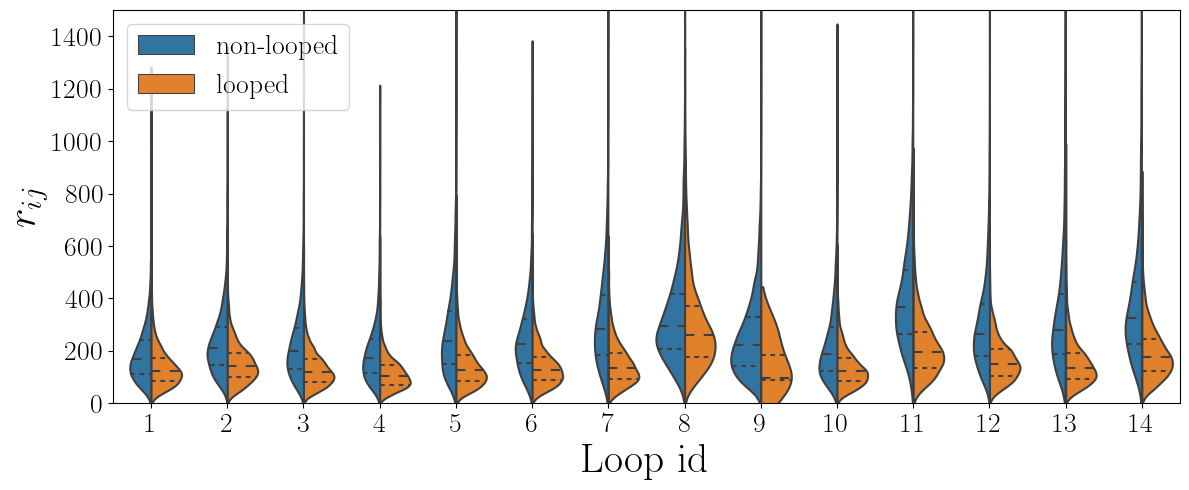

In [28]:
data_for_pd_untreated = np.zeros( (11631*14, 3) )


for k in range(14):
        data_for_pd_untreated[ 11631*k:11631*(k+1), 0] = np.round(saved_segragation_wt[k][:,0]).astype(bool)

        data_for_pd_untreated[ 11631*k:11631*(k+1), 1] = minimal_distance(0,k) #distances___(0,k)

        data_for_pd_untreated[ 11631*k:11631*(k+1), 2] = k+1


pddata_untreated = pd.DataFrame(data_for_pd_untreated, columns = ["looped", "distances", "loopid"] ) 



plt.figure(figsize=(12,5))

g = sb.violinplot(data=pddata_untreated, x='loopid', y='distances',hue = "looped", split=True, inner = "quart", native_scale=True)

plt.ylim(0, 1500)
#plt.ylim(0, 4)
#plt.ylim(0, 1e6)


#plt.plot( [10.5-1,10.5-1], [0, 1500], ":" )



plt.xlabel("Loop id", fontsize = 30)
plt.xticks( np.round(np.arange(0, 14)), np.round(np.arange(1, 14+1)) , fontsize=20)
plt.ylabel("$r_{ij}$", fontsize = 30)
plt.yticks(fontsize=20)

handles, labels = g.axes.get_legend_handles_labels()
plt.legend([handles[0], handles[1]], ["non-looped", "looped"], fontsize = 20, loc="upper left")


plt.tight_layout()

plt.savefig("./fig_io/violinplots_distances_endpoints_untreated.pdf", dpi=300, bbox_inches='tight')
plt.show()

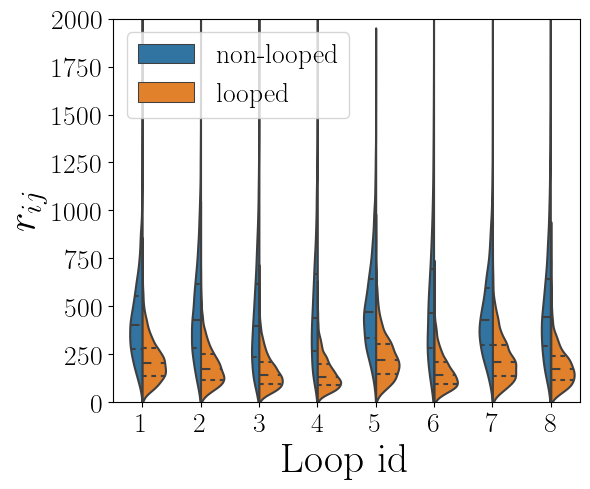

In [29]:
data_for_pd_auxin = np.empty( (9526*8, 3) )


for k in range(8):
        data_for_pd_auxin[ 9526*k:9526*(k+1), 0] = np.round(saved_segragation_A[k][:,0]).astype(bool)

        data_for_pd_auxin[ 9526*k:9526*(k+1), 1] = minimal_distance(1,k) #distances___(1,k)

        data_for_pd_auxin[ 9526*k:9526*(k+1), 2] = k+1



pddata_auxin = pd.DataFrame(data_for_pd_auxin, columns = ["looped", "distances", "loopid"] ) 


plt.figure(figsize=(6,5))

g = sb.violinplot(data=pddata_auxin, x='loopid', y='distances',hue = "looped", split=True, inner = "quart", native_scale=True)

plt.ylim(0, 2000)


plt.xlabel("Loop id", fontsize = 30)
plt.xticks( np.round(np.arange(0, 8)), np.round(np.arange(1, 8+1)) , fontsize=20)
plt.ylabel("$r_{ij}$", fontsize = 30)
plt.yticks(fontsize=20)


handles, labels = g.axes.get_legend_handles_labels()
plt.legend([handles[0], handles[1]], ["non-looped", "looped"], fontsize = 20, loc="upper left")

plt.tight_layout()

plt.savefig("./fig_io/violinplots_distances_endpoints_auxin.pdf", dpi=300, bbox_inches='tight')
plt.show()

## Correlations

In [30]:
all_classifiers = [saved_segragation_wt, saved_segragation_A]

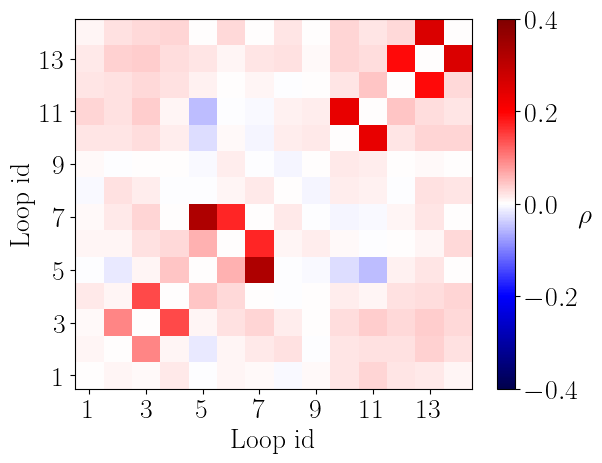

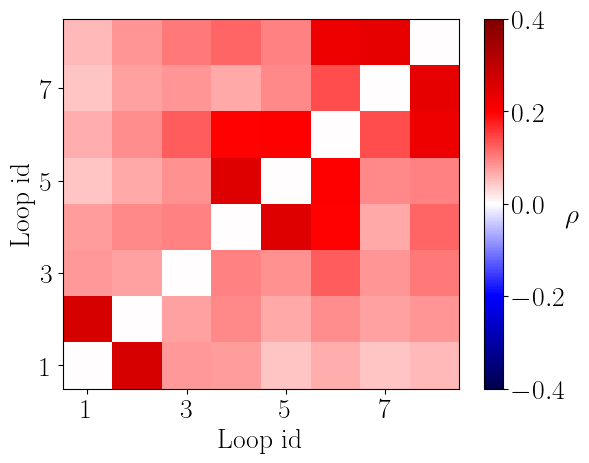

In [31]:
def corr_calc(X,Y):
    EXY = np.sum( X*Y) / len(X)
    EX = np.sum(X) / len(X)
    EY = np.sum(Y) / len(Y)


    EXX = np.sum(X**2) / len(X)
    EYY = np.sum(Y**2) / len(Y)

    
    #return (EXY - EX*EY) / np.sqrt((EX)*(EY)*(1-EX)*(1-EY))
    return (EXY - EX*EY) / np.sqrt((EXX-EX**2)*(EYY-EY**2))
    
    
for j in range(2):

    corr = np.zeros( (len(all_classifiers[j]),len(all_classifiers[j])) )
    for k1, classifier_1 in enumerate(all_classifiers[j]):
            for k2, classifier_2 in enumerate(all_classifiers[j]):
                  
                corr[k1,k2] = corr_calc( 2*classifier_1-1, 2*classifier_2-1 )

                corr[k1,k1] = 0

    im = plt.pcolormesh(np.arange(1, len(all_classifiers[j])+1), np.arange(1, len(all_classifiers[j])+1) , corr, vmin=-.4, vmax=.4, cmap = "seismic", linewidth=0,rasterized=True )
    cax = plt.colorbar(im)

    plt.xlabel('Loop id', fontsize = 20)
    plt.ylabel('Loop id', fontsize = 20)
    cax.ax.set_ylabel('$\\rho$', fontsize = 20, rotation=0)

    plt.tick_params(axis='both', labelsize=20)

    
    plt.xticks(np.arange(1, len(all_classifiers[j])+1, 2))
    plt.yticks(np.arange(1, len(all_classifiers[j])+1, 2))
    cax.ax.tick_params(axis='both', labelsize=20)
    
    if j == 0:
        add = "untreated"
    else:
        add= "auxin"
    name = "./fig_io/correlations_experiments_" + add + ".pdf"
    plt.savefig(name, bbox_inches='tight')

    plt.show()